In [1]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Health Project/'

Mounted at /content/drive


# **Load embeddings, build cohort, save data for training**

## Load libraries and setup environment

In [2]:

# Import libraries

!pip install tslearn
!pip install minisom
!pip install dtw-python
!pip install Levenshtein
!pip install optuna


from tslearn.metrics import cdist_dtw
from sklearn.cluster import AgglomerativeClustering
from minisom import MiniSom
from dtw import dtw

from datetime import timedelta
import os

import numpy as np
import pandas as pd
import seaborn as sns
import os

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

import bigframes.pandas as bf
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
pio.renderers.default = "colab"

from gensim.models import Word2Vec

from IPython.display import clear_output

import torch

import copy
import datetime
import sys




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11706 sha256=a33da3ee28c07574ecaf29acb151cd3831d4c4b4efa424bfec254b6abbef5b9a
  Stored in directory: /root/.cache/pip/wheels/96/98/a5/52dee3e8ed1dbfc4d77e4da41b6d89dd7ab9ead1b921e766f8
Successfully built minisom
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.7/764.7 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00
Importing the dtw module. When usi

In [3]:
bf.options.bigquery.location = "US"
bf.options.bigquery.project = 'loyal-mason-431106-n3' #'hellobigquery-431508'

# authenticate
auth.authenticate_user()

# Set up environment variables
project_id = 'loyal-mason-431106-n3' #'hellobigquery-431508'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id
dataset = 'mimiciv'


## **Load embedding mapping from itemid to vectors**

In [4]:
# load embedding vectors
df_itemid_to_vector = pd.read_csv(file_path + 'itemid_to_vector.csv')
itemid_to_vector = {str(key): value for key, value in df_itemid_to_vector.set_index('itemid').T.to_dict('list').items()}
print(len(itemid_to_vector))


418


## **Find patients with AD related ICD codes.**

Load all diagnoses icd table, and filter with our event list:

In [5]:
query = """
  SELECT
    d.*,
    a.dischtime AS discharge_time
  FROM
    `physionet-data.mimiciv_hosp.diagnoses_icd` AS d
  INNER JOIN
    `physionet-data.mimiciv_hosp.admissions` AS a
  ON
    d.hadm_id = a.hadm_id
  WHERE
    d.icd_code IN ('G300', 'G301', 'G308', 'G309', 'F0280', 'F0281', 'F0290', 'F0391', 'F04',
      'F060', 'F068', 'G3101', 'G3109', 'G311', 'G3183', 'G3185', 'G3189', 'G319',
      'G454', 'G937', 'G94', 'G910', 'G911', 'G912', 'F0150', 'F0151', 'I675',
      'I671', 'I672', 'I674', 'I676', 'I677', 'I6781', 'I6782', 'I6789', 'I679')

"""
df_ad_patients_with_discharge_time = bf.read_gbq(query)
print(len(df_ad_patients_with_discharge_time))
df_ad_patients_with_discharge_time.head(10)

# WHERE
    # d.icd_code IN ('G300', 'G301', 'G308', 'G309', 'F0280', 'F0281', 'F0290', 'F0391', 'F04',
    # 'F060', 'F068', 'G3101', 'G3109', 'G311', 'G3183', 'G3185', 'G3189', 'G319',
    # 'G454', 'G937', 'G94', 'G910', 'G911', 'G912', 'F0150', 'F0151', 'I675',
    # 'I671', 'I672', 'I674', 'I676', 'I677', 'I6781', 'I6782', 'I6789', 'I679',
    # '29012', '331', '2904', '29041', '29042', '29043', '294', '2948', '2949',
    # '2941', '29411', '2942', '29421', '3312', '3316', '3317', '33111', '33119',
    # '33181', '33182', '33189', '4377', '3313', '3314', '3315', '437', '4371',
    # '4372', '4373', '4374', '4375', '4376', '4378', '4379', '33183', '331',
    # '3311' )

7420


,subject_id,hadm_id,seq_num,icd_code,icd_version,discharge_time
0,17933761,20476026,4,F0280,10,2112-11-08 12:20:00
1,14945936,26868663,5,F0391,10,2203-05-28 15:32:00
2,19865666,27925490,13,F0280,10,2152-05-14 16:57:00
3,10707442,23962945,4,F0280,10,2147-06-21 14:38:00
4,19021878,20406937,9,F0280,10,2173-02-22 13:33:00
5,12864680,21022399,14,G3183,10,2144-10-11 15:02:00
6,15380556,27064881,1,I671,10,2141-08-30 15:45:00
7,14125217,22678449,10,I672,10,2182-06-27 15:30:00
8,19454731,23586324,3,I671,10,2134-08-02 17:50:00
9,18497825,23119353,14,F0280,10,2177-01-02 11:15:00


In [6]:
# df_ad_patients_with_discharge_time.head(10)

In [7]:
ad_patients_list = list(df_ad_patients_with_discharge_time.drop_duplicates(subset=['subject_id'])['subject_id'])
len(ad_patients_list)
# df_ad_patients

3947

## Possible Tests

## **See what tests are taken by these patients**

In [16]:
# See what labtests are taken for these patients

query = """
  SELECT
    d.subject_id,
    d.hadm_id,
    d.icd_code,
    d.icd_version,
    l.itemid,
    l.valuenum,
    l.valueuom,
    l.labevent_id,
    l.charttime,
    l.flag,
    dlab.label,
    dlab.fluid,
    dlab.category
  FROM
    (
      SELECT subject_id, hadm_id, icd_code, icd_version
      FROM `physionet-data.mimiciv_hosp.diagnoses_icd`
      WHERE icd_code IN ('G300', 'G301', 'G308', 'G309', 'F0280', 'F0281', 'F0290', 'F0391', 'F04',
            'F060', 'F068', 'G3101', 'G3109', 'G311', 'G3183', 'G3185', 'G3189', 'G319',
            'G454', 'G937', 'G94', 'G910', 'G911', 'G912', 'F0150', 'F0151', 'I675',
            'I671', 'I672', 'I674', 'I676', 'I677', 'I6781', 'I6782', 'I6789', 'I679')
    ) AS d
  INNER JOIN
    (
      SELECT subject_id, hadm_id, labevent_id, itemid, valuenum, valueuom, charttime, flag
      FROM `physionet-data.mimiciv_hosp.labevents`
      WHERE lower(flag) LIKE 'abnormal%'
        OR flag IS NULL
    ) AS l
  ON
    d.subject_id = l.subject_id
    AND d.hadm_id = l.hadm_id
  INNER JOIN
    `physionet-data.mimiciv_hosp.d_labitems` AS dlab
  ON
    l.itemid = dlab.itemid
    WHERE l.valuenum IS NOT NULL  -- remove NULL values
  # WHERE (LOWER(dlab.label) LIKE '%csf' OR
  #  LOWER(dlab.label) LIKE'%b12%')
"""
df_ad_patients_lab_results = bf.read_gbq(query).sort_values(by=['subject_id', 'charttime', 'labevent_id']).reset_index(drop=True)
print(len(df_ad_patients_lab_results))
df_ad_patients_lab_results.head(10)


1385974


,subject_id,hadm_id,icd_code,icd_version,itemid,valuenum,valueuom,labevent_id,charttime,flag,label,fluid,category
0,10000084,23052089,F0280,10,51133,2.86,K/uL,672,2160-11-20 22:30:00,<NA>,Absolute Lymphocyte Count,Blood,Hematology
1,10000084,23052089,G3183,10,51133,2.86,K/uL,672,2160-11-20 22:30:00,<NA>,Absolute Lymphocyte Count,Blood,Hematology
2,10000084,23052089,F0280,10,51146,0.6,%,673,2160-11-20 22:30:00,<NA>,Basophils,Blood,Hematology
3,10000084,23052089,G3183,10,51146,0.6,%,673,2160-11-20 22:30:00,<NA>,Basophils,Blood,Hematology
4,10000084,23052089,G3183,10,51200,2.0,%,674,2160-11-20 22:30:00,<NA>,Eosinophils,Blood,Hematology
5,10000084,23052089,F0280,10,51200,2.0,%,674,2160-11-20 22:30:00,<NA>,Eosinophils,Blood,Hematology
6,10000084,23052089,G3183,10,51221,38.2,%,675,2160-11-20 22:30:00,abnormal,Hematocrit,Blood,Hematology
7,10000084,23052089,F0280,10,51221,38.2,%,675,2160-11-20 22:30:00,abnormal,Hematocrit,Blood,Hematology
8,10000084,23052089,G3183,10,51222,12.8,g/dL,676,2160-11-20 22:30:00,abnormal,Hemoglobin,Blood,Hematology
9,10000084,23052089,F0280,10,51222,12.8,g/dL,676,2160-11-20 22:30:00,abnormal,Hemoglobin,Blood,Hematology


For each patient, only keep the test data with charttime before their diagnoses' dischargetime

In [17]:
df_temp = df_ad_patients_with_discharge_time[['subject_id', 'hadm_id', 'discharge_time']].drop_duplicates(subset=['subject_id', 'hadm_id']).to_pandas()
df_ad_patients_lab_results_pd = df_ad_patients_lab_results.to_pandas()

df_ad_patients_lab_results_pd = pd.merge(df_ad_patients_lab_results_pd, df_temp, on=['subject_id', 'hadm_id'], how='left')

df_ad_patients_lab_results_pd = df_ad_patients_lab_results_pd[df_ad_patients_lab_results_pd['charttime'] <= df_ad_patients_lab_results_pd['discharge_time']].reset_index(drop=True)

print(len(df_ad_patients_lab_results_pd))
df_ad_patients_lab_results_pd.head(10)


1385218


,subject_id,hadm_id,icd_code,icd_version,itemid,valuenum,valueuom,labevent_id,charttime,flag,label,fluid,category,discharge_time
0,10000084,23052089,F0280,10,51133,2.86,K/uL,672,2160-11-20 22:30:00,<NA>,Absolute Lymphocyte Count,Blood,Hematology,2160-11-25 14:52:00
1,10000084,23052089,G3183,10,51133,2.86,K/uL,672,2160-11-20 22:30:00,<NA>,Absolute Lymphocyte Count,Blood,Hematology,2160-11-25 14:52:00
2,10000084,23052089,F0280,10,51146,0.6,%,673,2160-11-20 22:30:00,<NA>,Basophils,Blood,Hematology,2160-11-25 14:52:00
3,10000084,23052089,G3183,10,51146,0.6,%,673,2160-11-20 22:30:00,<NA>,Basophils,Blood,Hematology,2160-11-25 14:52:00
4,10000084,23052089,G3183,10,51200,2.0,%,674,2160-11-20 22:30:00,<NA>,Eosinophils,Blood,Hematology,2160-11-25 14:52:00
5,10000084,23052089,F0280,10,51200,2.0,%,674,2160-11-20 22:30:00,<NA>,Eosinophils,Blood,Hematology,2160-11-25 14:52:00
6,10000084,23052089,G3183,10,51221,38.2,%,675,2160-11-20 22:30:00,abnormal,Hematocrit,Blood,Hematology,2160-11-25 14:52:00
7,10000084,23052089,F0280,10,51221,38.2,%,675,2160-11-20 22:30:00,abnormal,Hematocrit,Blood,Hematology,2160-11-25 14:52:00
8,10000084,23052089,G3183,10,51222,12.8,g/dL,676,2160-11-20 22:30:00,abnormal,Hemoglobin,Blood,Hematology,2160-11-25 14:52:00
9,10000084,23052089,F0280,10,51222,12.8,g/dL,676,2160-11-20 22:30:00,abnormal,Hemoglobin,Blood,Hematology,2160-11-25 14:52:00


In [18]:
df_ad_patients_lab_results_pd = df_ad_patients_lab_results.to_pandas()
df_ad_patients_lab_results_pd['itemid'] = df_ad_patients_lab_results_pd['itemid'].astype(str)
df_ad_patients_lab_results_pd.dtypes

,0
subject_id,Int64
hadm_id,Int64
icd_code,string[pyarrow]
icd_version,Int64
itemid,object
valuenum,Float64
valueuom,string[pyarrow]
labevent_id,Int64
charttime,timestamp[us][pyarrow]
flag,string[pyarrow]


In [19]:
# see how many unique patients:
print(len(df_ad_patients_lab_results_pd['subject_id'].unique()))

3764


In [20]:
possible_tests = bf.read_gbq("""
  SELECT *
  FROM `physionet-data.mimiciv_hosp.d_labitems`
""")
ad_tests = list(set(df_ad_patients_lab_results['itemid']))
ad_test_names = possible_tests[possible_tests['itemid'].isin(ad_tests)].to_pandas()
ad_test_names['itemid'] = ad_test_names['itemid'].astype(str)

ad_test_names.head(1)

,itemid,label,fluid,category
5,51203,Factor IX,Blood,Hematology


In [21]:
itemid_counts_df = df_ad_patients_lab_results_pd.groupby('itemid')['subject_id'].nunique().reset_index()
itemid_counts_df.columns = ['itemid', 'count']
itemid_counts_df['itemid'] = itemid_counts_df['itemid'].astype(str)


merged_df = pd.merge(itemid_counts_df, ad_test_names, on='itemid', how='inner')

merged_df_sorted = merged_df.sort_values(by='count', ascending=False)

merged_df_sorted

,itemid,count,label,fluid,category
70,50912,3729,Creatinine,Blood,Chemistry
130,51006,3728,Urea Nitrogen,Blood,Chemistry
107,50971,3727,Potassium,Blood,Chemistry
60,50902,3722,Chloride,Blood,Chemistry
46,50882,3722,Bicarbonate,Blood,Chemistry
...,...,...,...,...,...
377,52129,1,Hemoglobin Other,Blood,Hematology
352,51772,1,PAN3,Blood,Chemistry
33,50850,1,"Triglycerides, Ascites",Ascites,Chemistry
156,51072,1,"Amylase, Urine",Urine,Chemistry


### **Apply Word2vec embedding, treating each patient's test history as a "sentence" and each labtest as a "word".**

Prepare the sentences:

In [51]:
query = """
  SELECT
    subject_id,
    STRING_AGG(CAST(itemid AS STRING) ORDER BY charttime ASC) AS itemid_sequence,  -- ASC for time order
    ARRAY_AGG(CAST(valuenum AS FLOAT64) ORDER BY charttime ASC) AS test_value_sequence,  -- ASC for time order
    ARRAY_LENGTH(ARRAY_AGG(itemid ORDER BY charttime ASC)) AS sequence_length,
    STRING_AGG(DISTINCT icd_code ORDER BY icd_code ASC) AS icd_codes,
    'mimic_iv' AS data_source,  -- New column with constant value 'mimic_iv'
    CASE
        WHEN REGEXP_CONTAINS(STRING_AGG(DISTINCT filtered.icd_code ORDER BY filtered.icd_code ASC), r'G30.*')
        OR REGEXP_CONTAINS(STRING_AGG(DISTINCT filtered.icd_code ORDER BY filtered.icd_code ASC), r'331.*')
        THEN 1
        ELSE 0
    END AS label_ad  -- New column that marks Alzheimer's Disease based on G30 ICD codes
  FROM (
    SELECT
        d.subject_id,
        l.itemid,
        l.valuenum,
        l.charttime,
        d.icd_code,
        ROW_NUMBER() OVER (PARTITION BY d.subject_id, l.itemid ORDER BY l.charttime ASC) AS rn
    FROM
        physionet-data.mimiciv_hosp.diagnoses_icd AS d
    JOIN
        physionet-data.mimiciv_hosp.labevents AS l
    ON
        d.subject_id = l.subject_id
    JOIN
        physionet-data.mimiciv_hosp.admissions AS a
    ON
        l.subject_id = a.subject_id
    JOIN
      physionet-data.mimiciv_hosp.d_labitems AS dlab
    ON
      l.itemid = dlab.itemid
    WHERE
      (
        d.icd_code LIKE 'G30%' OR
        d.icd_code LIKE 'F01%' OR
        d.icd_code LIKE 'F03%' OR
        d.icd_code LIKE 'F02%' OR
        d.icd_code LIKE 'R54%' OR

        d.icd_code IN ('G318', 'G310', 'G311', 'G318', 'G319', '3310', '3311', '3312', '3319', '2904', '2900', '2901', '2902', '2903', '2908', '2909', '797')
      )
      AND l.valuenum IS NOT NULL
      # AND l.charttime <= a.dischtime
      AND l.hadm_id < a.hadm_id  -- Only include hadm_id before first AD diagnosis
      AND (LOWER(l.flag) LIKE 'abnormal%' OR l.flag IS NULL)
      # AND (LOWER(l.flag) LIKE 'abnormal%')
      AND lower(dlab.fluid) LIKE '%blood%'

  ) AS filtered
  WHERE
    rn <= 2  -- only keep the first two entries for each itemid per patient
  GROUP BY
    subject_id
  ORDER BY
    subject_id;
"""




df_itemid_sequences_4 = bf.read_gbq(query)
print(len(df_itemid_sequences_4))
df_itemid_sequences_4.head(10)


3620


,subject_id,itemid_sequence,test_value_sequence,sequence_length,icd_codes,data_source,label_ad
0,13110963,"51222,51222,50882,50882,51301,51301,50971,5097...",[ 9.000e+00 9.000e+00 2.800e+01 2.800e+01 ...,108,"2900,3310",mimic_iv,1
1,13098031,"51265,51248,50971,51221,51250,51006,50882,5127...",[201. 33. 3.6 29.6 93. 24. 27...,64,3310,mimic_iv,1
2,15448346,"51251,51251,50970,50970,51265,51265,51248,5124...",[ 0.00e+00 0.00e+00 3.90e+00 3.90e+00 9.50...,134,3310,mimic_iv,1
3,19706404,"50912,51222,51250,51279,51265,51277,50971,5100...",[ 1.5 11. 104. 3.38 109. 17.6 5...,45,3310,mimic_iv,1
4,10369817,"50902,51265,51221,50983,50893,50960,50971,5124...",[ 1.07e+02 3.08e+02 3.25e+01 1.40e+02 8.30...,123,F0390,mimic_iv,0
5,11009860,"50907,50907,51254,51254,51265,51265,50983,5098...",[111. 111. 6. 6. 136. 136. 143...,84,"3310,3319",mimic_iv,1
6,15056964,"50862,50862,51244,51244,50931,50931,51265,5126...",[3.70e+00 3.70e+00 3.38e+01 3.38e+01 1.05e+02 ...,122,F0151,mimic_iv,0
7,17513267,"50882,50882,51277,51277,51244,51244,51256,5125...",[ 26. 26. 11.8 11.8 37.6 37.6 53...,104,3310,mimic_iv,1
8,14025516,"50878,50878,50882,50882,51010,51010,50983,5098...",[ 2.400e+01 2.400e+01 3.100e+01 3.100e+01 ...,150,F0281,mimic_iv,0
9,19525970,"50907,50852,50905,50904,51000,50903",[184. 6. 88. 77. 94. 2.4],6,3310,mimic_iv,1


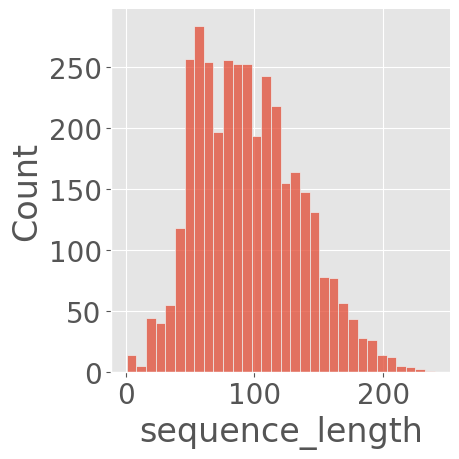

In [52]:
# prompt: plot distribution of df_itemid_sequences['sequence_length']
df_labtest_sequences_pd_4 = df_itemid_sequences_4.to_pandas()
sns.displot(df_labtest_sequences_pd_4['sequence_length'])


In [53]:
print(df_labtest_sequences_pd_4['sequence_length'].max())
print(df_labtest_sequences_pd_4['sequence_length'].min())

240
1


In [54]:
print(df_labtest_sequences_pd_4.dtypes)

subject_id                                   Int64
itemid_sequence                    string[pyarrow]
test_value_sequence    list<item: double>[pyarrow]
sequence_length                              Int64
icd_codes                          string[pyarrow]
data_source                        string[pyarrow]
label_ad                                     Int64
dtype: object


### **Similarly for MIMIC_III**

In [55]:
query = """
  SELECT
    subject_id,
    STRING_AGG(CAST(itemid AS STRING) ORDER BY charttime ASC) AS itemid_sequence,  -- ASC for time order
    ARRAY_AGG(CAST(valuenum AS FLOAT64) ORDER BY charttime ASC) AS test_value_sequence,  -- ASC for time order
    ARRAY_LENGTH(ARRAY_AGG(itemid ORDER BY charttime ASC)) AS sequence_length,
    STRING_AGG(DISTINCT icd9_code ORDER BY icd9_code ASC) AS icd_codes,
    'mimic_iii' AS data_source,
    CASE WHEN STRING_AGG(DISTINCT icd9_code ORDER BY icd9_code ASC) LIKE '331%' THEN 1 ELSE 0 END AS label_ad
  FROM (
    SELECT
      d.subject_id,
      l.itemid,
      l.valuenum,
      l.charttime,
      d.icd9_code,
      ROW_NUMBER() OVER (PARTITION BY d.subject_id, l.itemid ORDER BY l.charttime ASC) AS rn
    FROM
        `physionet-data.mimiciii_clinical.diagnoses_icd` AS d
    JOIN
        `physionet-data.mimiciii_clinical.labevents` AS l
    ON
        d.subject_id = l.subject_id
    JOIN
        `physionet-data.mimiciii_clinical.admissions` AS a
    ON
        l.subject_id = a.subject_id
    INNER JOIN
      `physionet-data.mimiciii_clinical.d_labitems` AS dlab
    ON
      l.itemid = dlab.itemid
    WHERE
      d.icd9_code LIKE '331%'  -- ICD-9 codes for Alzheimer's and related diseases
      AND l.valuenum IS NOT NULL
      # AND l.charttime <= a.dischtime
      AND l.hadm_id < a.hadm_id  -- Only include hadm_id before first AD diagnosis
      AND (LOWER(l.flag) LIKE 'abnormal%' OR l.flag IS NULL)
      # AND (LOWER(l.flag) LIKE 'abnormal%')
      AND lower(dlab.fluid) LIKE '%blood%'


  ) AS filtered
  WHERE
    rn <= 2  -- only keep the first two entries for each itemid per patient
  GROUP BY
    subject_id
  ORDER BY
    subject_id;
"""
df_itemid_sequences_3 = bf.read_gbq(query)
print(len(df_itemid_sequences_3))
df_itemid_sequences_3.head(10)

307


,subject_id,itemid_sequence,test_value_sequence,sequence_length,icd_codes,data_source,label_ad
0,66507,"51237,51275,51274,51250,50970,50912,50960,5100...",[ 1.1 141.5 12.9 92. 3.7 0.6 2...,46,3314,mimic_iii,1
1,93593,"51222,50912,50893,50960,51254,51248,51274,5093...",[ 8.8 0.6 8. 1.7 6.6 30.3 14...,57,3310,mimic_iii,1
2,30105,"50867,51256,51277,51249,50952,50935,51222,5124...",[ 6.30e+01 8.17e+01 1.34e+01 3.37e+01 1.03...,94,3310,mimic_iii,1
3,17863,"50983,50983,51301,51301,51248,51248,51200,5120...",[1.37e+02 1.37e+02 2.80e+01 2.80e+01 3.09e+01 ...,138,3310,mimic_iii,1
4,6024,"50867,51144,51006,50861,50983,50971,51256,5086...",[ 1.460e+02 0.000e+00 2.000e+01 2.000e+01 ...,183,3310,mimic_iii,1
5,8472,"51250,51250,50967,50967,50882,50882,51222,5122...",[8.00e+01 8.00e+01 3.30e+00 3.30e+00 2.80e+01 ...,96,"3313,3314",mimic_iii,1
6,80847,"50912,50804,50821,51221,51277,51006,51248,5130...",[ 8.000e-01 2.200e+01 6.800e+01 3.760e+01 ...,99,3314,mimic_iii,1
7,53470,"50882,50882,50960,50960,51279,51279,51244,5124...",[2.600e+01 2.600e+01 1.700e+00 1.700e+00 3.500...,60,33119,mimic_iii,1
8,93900,"51146,51146,51237,51237,51279,51279,50863,5086...",[3.0000e-01 3.0000e-01 1.2000e+00 1.2000e+00 3...,134,3310,mimic_iii,1
9,54121,"51249,51248,50956,51221,50912,51301,51006,5127...",[ 3.43e+01 2.99e+01 2.40e+01 3.56e+01 7.00...,131,3314,mimic_iii,1


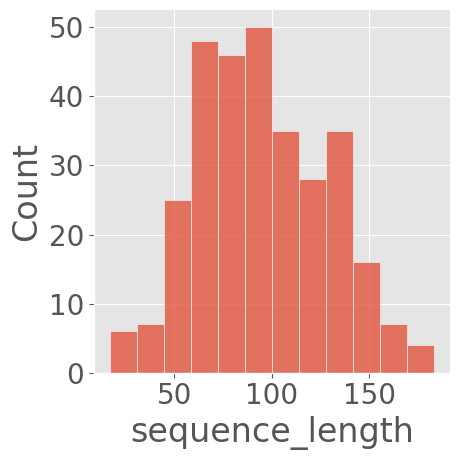

In [56]:
df_labtest_sequences_pd_3 = df_itemid_sequences_3.to_pandas()
sns.displot(df_labtest_sequences_pd_3['sequence_length'])

In [57]:
df_labtest_sequences_pd_3.head()

,subject_id,itemid_sequence,test_value_sequence,sequence_length,icd_codes,data_source,label_ad
0,66507,"51237,51275,51274,51250,50970,50912,50960,5100...",[ 1.1 141.5 12.9 92. 3.7 0.6 2...,46,3314,mimic_iii,1
1,93593,"51222,50912,50893,50960,51254,51248,51274,5093...",[ 8.8 0.6 8. 1.7 6.6 30.3 14...,57,3310,mimic_iii,1
2,30105,"50867,51256,51277,51249,50952,50935,51222,5124...",[ 6.30e+01 8.17e+01 1.34e+01 3.37e+01 1.03...,94,3310,mimic_iii,1
3,17863,"50983,50983,51301,51301,51248,51248,51200,5120...",[1.37e+02 1.37e+02 2.80e+01 2.80e+01 3.09e+01 ...,138,3310,mimic_iii,1
4,6024,"50867,51144,51006,50861,50983,50971,51256,5086...",[ 1.460e+02 0.000e+00 2.000e+01 2.000e+01 ...,183,3310,mimic_iii,1


**Combine data fromo mimic iii and iv**

Skewness: 0.40650620602877285


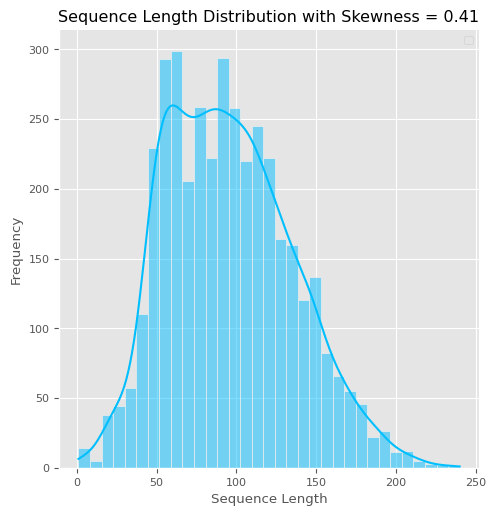

In [58]:
# df_labtest_sequences_pd = df_itemid_sequences.to_pandas()
df_labtest_sequences_pd = pd.concat([df_labtest_sequences_pd_4, df_labtest_sequences_pd_3], ignore_index=True)

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

plt.rcParams.update({'font.size': 8})

sns.displot(df_labtest_sequences_pd['sequence_length'], kde=True, color='#00BFFF')

skewness = df_labtest_sequences_pd['sequence_length'].skew()
print(f'Skewness: {skewness}')

plt.title(f'Sequence Length Distribution with Skewness = {skewness:.2f}')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [59]:
for i in range(len(df_labtest_sequences_pd)):
  seq = df_labtest_sequences_pd.loc[i, 'itemid_sequence']
  if '52285' in seq:
    print(seq)

**Split itemid sequences, save dataframe**

In [60]:
import ast


df_labtest_sequences_pd['itemid_sequence'] = df_labtest_sequences_pd['itemid_sequence'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
# df_labtest_sequences_pd['test_value_sequence'] = df_labtest_sequences_pd['test_value_sequence'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
# df_labtest_sequences_pd.to_csv(file_path + 'df_labtest_sequences_pd.csv', index=False)

# patients_itemid_seqs = df_labtest_sequences_pd['itemid_sequence']
# patients_itemid_seqs[:1]
df_labtest_sequences_pd

,subject_id,itemid_sequence,test_value_sequence,sequence_length,icd_codes,data_source,label_ad
0,13110963,"[51222, 51222, 50882, 50882, 51301, 51301, 509...",[ 9.000e+00 9.000e+00 2.800e+01 2.800e+01 ...,108,"2900,3310",mimic_iv,1
1,13098031,"[51265, 51248, 50971, 51221, 51250, 51006, 508...",[201. 33. 3.6 29.6 93. 24. 27...,64,3310,mimic_iv,1
2,15448346,"[51251, 51251, 50970, 50970, 51265, 51265, 512...",[ 0.00e+00 0.00e+00 3.90e+00 3.90e+00 9.50...,134,3310,mimic_iv,1
3,19706404,"[50912, 51222, 51250, 51279, 51265, 51277, 509...",[ 1.5 11. 104. 3.38 109. 17.6 5...,45,3310,mimic_iv,1
4,10369817,"[50902, 51265, 51221, 50983, 50893, 50960, 509...",[ 1.07e+02 3.08e+02 3.25e+01 1.40e+02 8.30...,123,F0390,mimic_iv,0
...,...,...,...,...,...,...,...
3922,6069,"[51275, 51275, 51146, 51146, 50970, 50970, 509...",[ 2.450e+01 2.450e+01 3.000e-01 3.000e-01 ...,140,"3310,33183",mimic_iii,1
3923,16265,"[51301, 50931, 50902, 51274, 51279, 51248, 509...",[1.16e+01 1.49e+02 1.03e+02 1.31e+01 3.32e+00 ...,93,3314,mimic_iii,1
3924,20101,"[50893, 50956, 50971, 50882, 51248, 51301, 512...",[9.200e+00 6.900e+01 4.000e+00 2.700e+01 2.960...,136,33182,mimic_iii,1
3925,62925,"[51006, 51006, 51277, 51277, 51221, 51221, 512...",[6.50e+01 6.50e+01 1.64e+01 1.64e+01 3.07e+01 ...,80,3310,mimic_iii,1


In [61]:
# df_labtest_sequences_pd = pd.read_csv('df_labtest_sequences_pd.csv')
print(len(df_labtest_sequences_pd))
df_labtest_sequences_pd.head(1)

3927


,subject_id,itemid_sequence,test_value_sequence,sequence_length,icd_codes,data_source,label_ad
0,13110963,"[51222, 51222, 50882, 50882, 51301, 51301, 509...",[ 9.000e+00 9.000e+00 2.800e+01 2.800e+01 ...,108,"2900,3310",mimic_iv,1


In [62]:
df_labtest_sequences_pd.dtypes

,0
subject_id,Int64
itemid_sequence,object
test_value_sequence,list<item: double>[pyarrow]
sequence_length,Int64
icd_codes,string[pyarrow]
data_source,string[pyarrow]
label_ad,Int64


# **Apply scalers for each labtest**

**Train scalers for each labtest itemid based on global data**

In [63]:
# from sklearn.preprocessing import RobustScaler

# labtest_scalers = {}
# outlier_ranges = []

# unique_itemids = df_ad_patients_lab_results_pd['itemid'].unique()
# num_itemids = len(unique_itemids)

# for i in range(num_itemids):
#   itemid = unique_itemids[i]

#   item_values = df_ad_patients_lab_results_pd[df_ad_patients_lab_results_pd['itemid'] == itemid]['valuenum'].dropna()
#   # print(f"Processing Itemid: {itemid}, values: {item_values}")

#   if item_values.empty:
#     print(f"Itemid: {itemid} has no valid data, skipping.")
#     continue


#   if item_values.size == 0:
#     print(f"Itemid: {itemid} has no valid data, skipping.")
#     continue

#   sys.stdout.write(f"\rProcessing itemid {itemid} , {i + 1}/{num_itemids} ({(i + 1) / num_itemids * 100:.2f}%)")
#   sys.stdout.flush()

#   item_values_array = item_values.values.reshape(-1, 1)


#   scaler = RobustScaler()
#   scaler.fit(item_values_array)

#   labtest_scalers[itemid] = scaler



In [64]:
# print(len(labtest_scalers))
# print(labtest_scalers)

**save scaler**

In [65]:
# import pickle

# with open(file_path + 'labtest_scalers.pkl', 'wb') as file:
#     pickle.dump(labtest_scalers, file)

**Concatenate vectors of patients to matrices**


In [66]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
import sys

df_all = copy.deepcopy(df_labtest_sequences_pd)

# df_all['itemid_sequence'] = df_all['itemid_sequence'].apply(lambda x: list(x) if isinstance(x, list) else x)
df_all['test_value_sequence'] = df_all['test_value_sequence'].apply(lambda x: list(x) if isinstance(x, list) else x)


df_all['matrix'] = None
df_all['scaled_value_sequence'] = None

missing_scaler_count = defaultdict(int)
missing_pca_vector_count = defaultdict(int)
outlier_count = defaultdict(int)

num_patients = len(df_all)

for i in range(len(df_all)):

  patient_matrix = []
  updated_itemid_sequence = []
  updated_test_value_sequence = []
  scaled_values = []

  sys.stdout.write(f"\rProcessing patient {i + 1}/{num_patients} ({(i + 1) / num_patients * 100:.2f}%)")
  sys.stdout.flush()

  itemid_sequence = df_all.loc[i, 'itemid_sequence']
  test_value_sequence = df_all.loc[i, 'test_value_sequence']
  # print(itemid_sequence)
  # print(test_value_sequence)

  # Iterate through itemid and test_value
  for itemid, test_value in zip(itemid_sequence, test_value_sequence):
    if itemid == '52285':
      print(itemid, test_value)
    #
    # print(itemid, test_value)
    # scaler = labtest_scalers.get(itemid)
    # if scaler is None:
    #     missing_scaler_count[itemid] += 1
    #     continue  # Skip if no scaler for the itemid

    # item_range = df_outlier_ranges[df_outlier_ranges['itemid'] == itemid]
    # # print(item_range)
    # lower_bound = item_range['lower_bound'].values[0] if not item_range.empty else None
    # upper_bound = item_range['upper_bound'].values[0] if not item_range.empty else None

    # if lower_bound is not None and upper_bound is not None:
    #     if test_value < lower_bound or test_value > upper_bound:
    #         outlier_count[itemid] += 1
    #         continue  # Skip if the test value is outside the outlier range
    # else:
    #     print(f"No outlier range found for itemid: {itemid}")
    #     continue


    pca_vector = itemid_to_vector.get(str(itemid))
    if pca_vector is None:
        missing_pca_vector_count[itemid] += 1
        continue  # Skip if no PCA vector for the itemid

    # Combine the 20-dim PCA vector with the test value to form a 21-dim vector
    test_value_array = np.array(test_value).reshape(-1, 1)

    # test_value_scaled = scaler.transform(test_value_array)
    # print(test_value, test_value_scaled)

    # combined_vector = np.append(pca_vector, test_value_scaled)
    combined_vector = np.append(pca_vector, test_value)

    patient_matrix.append(combined_vector)
    # print(combined_vector)

    # Update sequences
    updated_itemid_sequence.append(itemid)
    updated_test_value_sequence.append(test_value)
    # scaled_values.append(test_value_scaled.item())

  # Update the patient's matrix and sequences in the DataFrame
  df_all.at[i, 'matrix'] = patient_matrix
  df_all.at[i, 'itemid_sequence'] = updated_itemid_sequence
  df_all.at[i, 'test_value_sequence'] = updated_test_value_sequence
  df_all.at[i, 'sequence_length'] = len(updated_itemid_sequence)
  # df_all.at[i, 'scaled_value_sequence'] = scaled_values

print('\n')
print(df_all.head(1))
print(f"Number of patients: {len(df_all)}")
# print(f"Number of values with missing scaler: {missing_scaler_count}")
print(f"Number of values with missing pca vector: {missing_pca_vector_count}")
print(f"Number of values outside outlier range: {outlier_count}")

df_all = df_all[df_all['sequence_length'] >= 4].reset_index(drop=True)
df_all.head(5)


Processing patient 3927/3927 (100.00%)

   subject_id                                    itemid_sequence  \
0    13110963  [51222, 51222, 50882, 50882, 51301, 51301, 509...   

                                 test_value_sequence  sequence_length  \
0  [9.0, 9.0, 28.0, 28.0, 5.5, 5.5, 3.9, 3.9, 55....              108   

   icd_codes data_source  label_ad  \
0  2900,3310    mimic_iv         1   

                                              matrix scaled_value_sequence  
0  [[-1.5628095, 0.45193323, 0.77758604, 0.540392...                  None  
Number of patients: 3927
Number of values with missing pca vector: defaultdict(<class 'int'>, {'52129': 2, '51208': 9, '51202': 7, '51752': 1, '50916': 4, '51170': 3, '51165': 3, '51169': 3, '51166': 3, '51767': 4, '51765': 2, '50898': 12, '51233': 3, '51772': 1, '51648': 1, '50877': 2, '50990': 2, '51209': 2, '51203': 4, '51210': 2, '51726': 4, '52132': 4, '51199': 2, '51252': 1, '51246': 1, '51694': 2, '51769': 2, '51270': 2, '51272': 2, '

,subject_id,itemid_sequence,test_value_sequence,sequence_length,icd_codes,data_source,label_ad,matrix,scaled_value_sequence
0,13110963,"[51222, 51222, 50882, 50882, 51301, 51301, 509...","[9.0, 9.0, 28.0, 28.0, 5.5, 5.5, 3.9, 3.9, 55....",108,"2900,3310",mimic_iv,1,"[[-1.5628095, 0.45193323, 0.77758604, 0.540392...",None
1,13098031,"[51265, 51248, 50971, 51221, 51250, 51006, 508...","[201.0, 33.0, 3.6, 29.6, 93.0, 24.0, 27.0, 3.1...",64,3310,mimic_iv,1,"[[-1.4373171, 0.56306213, 0.7621986, 0.6871784...",None
2,15448346,"[51251, 51251, 50970, 50970, 51265, 51265, 512...","[0.0, 0.0, 3.9, 3.9, 95.0, 95.0, 28.8, 28.8, 4...",134,3310,mimic_iv,1,"[[-0.8060599, 0.008011532, -0.26729253, -0.419...",None
3,19706404,"[50912, 51222, 51250, 51279, 51265, 51277, 509...","[1.5, 11.0, 104.0, 3.38, 109.0, 17.6, 5.5, 44....",45,3310,mimic_iv,1,"[[-1.4755245, 0.6031277, 0.70336694, 0.7012964...",None
4,10369817,"[50902, 51265, 51221, 50983, 50893, 50960, 509...","[107.0, 308.0, 32.5, 140.0, 8.3, 1.9, 4.2, 32....",123,F0390,mimic_iv,0,"[[-1.4061024, 0.61299014, 0.7996875, 0.6833367...",None


# **save matrix df** (not fixed yet) **df_labtest_sequences_pd_pre_blood.csv**

In [46]:
# df_all['matrix'] = df_all['matrix'].apply(lambda x: str(x))
# df_all.to_csv(file_path + 'df_labtest_sequences_pd_pre_blood.csv', index=False)
# np.save(file_path + 'matrix_data_pre_blood.npy', df_all['matrix'].values)

In [47]:
# df_all = pd.read_csv(file_path + 'df_labtest_sequences_pd_pre_blood.csv')
# df_all['matrix'] = df_all['matrix'].apply(lambda x: np.array(eval(x, {'array': np.array})))


In [48]:

# df_labtest_sequences_pd = copy.deepcopy(df_all)
# df_all.head(1)

,subject_id,itemid_sequence,test_value_sequence,sequence_length,icd_codes,data_source,label_ad,matrix,scaled_value_sequence
0,18701270,"['51237', '51237', '50983', '50983', '50947', ...","[1.1, 1.1, 142.0, 142.0, 1.0, 1.0, 100.0, 100....",30,"F0391,G309",mimic_iv,1,"[[-1.1360576, 0.38558385, 0.44497946, 0.311760...",NaN


# **Transformer**

mTAND (Multivariate Time-series Autoencoder for Neural Decoding) is used for learning representations from multivariate time-series data, particularly in neurobiology or brain signal decoding tasks. It is an autoencoder-based architecture, often used for dimensionality reduction, feature extraction, and decoding.

1.PCA

2.Wrod2Vec / BERT

3.mTAND

4.Positional Embedding

5.build and fit Transformer


## random seeds

In [67]:
random_seed = 42
df_labtest_transformer = copy.deepcopy(df_all)
# df_labtest_transformer.head()

import torch
import random
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
# torch.backends.cudnn.deterministic = True  # if use GPU
# torch.backends.cudnn.benchmark = False

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import os

## prepare data

In [69]:
# Define a directory to save the model checkpoints
checkpoint_dir = file_path + '/model_checkpoints/pre_blood'
os.makedirs(checkpoint_dir, exist_ok=True)

let's prepare the training data by adding label

In [70]:

# True for label_ad == 1
df_labtest_transformer['label'] = df_labtest_transformer['label_ad'].apply(lambda x: True if x == 1 else False)

# data distribution
print("Initial Distribution of Labels (True for Alzheimer's, False for Other):")
print(df_labtest_transformer['label'].value_counts())
print(df_labtest_transformer.shape)

Initial Distribution of Labels (True for Alzheimer's, False for Other):
label
False    2292
True     1630
Name: count, dtype: int64
(3922, 10)


In [71]:
df_labtest_transformer.head(2)

,subject_id,itemid_sequence,test_value_sequence,sequence_length,icd_codes,data_source,label_ad,matrix,scaled_value_sequence,label
0,13110963,"[51222, 51222, 50882, 50882, 51301, 51301, 509...","[9.0, 9.0, 28.0, 28.0, 5.5, 5.5, 3.9, 3.9, 55....",108,"2900,3310",mimic_iv,1,"[[-1.5628095, 0.45193323, 0.77758604, 0.540392...",None,True
1,13098031,"[51265, 51248, 50971, 51221, 51250, 51006, 508...","[201.0, 33.0, 3.6, 29.6, 93.0, 24.0, 27.0, 3.1...",64,3310,mimic_iv,1,"[[-1.4373171, 0.56306213, 0.7621986, 0.6871784...",None,True


label_ad is integer of label: 1-ad patient; 0-not

In [72]:
print(df_labtest_transformer.shape)
print(df_labtest_transformer['label'].shape)

(3922, 10)
(3922,)


In [73]:

# Prepare the dataset (train/test split, label adjustments, etc.)
train_df, eval_df = train_test_split(df_labtest_transformer, test_size=0.1, random_state=random_seed, stratify=df_labtest_transformer['label'])

# Data processing and resampling
# Resample True
true_train_df = train_df[train_df['label'] == True]
duplicated_true_train_df = pd.concat([true_train_df] * 1)  # Change number for re-sampling

# Downsample False
false_train_df = train_df[train_df['label'] == False]
filtered_false_train_df = false_train_df[false_train_df['sequence_length'] >= 4]
downsampled_false_train_df = filtered_false_train_df.sample(frac=0.7, random_state=random_seed)

# Combine resampled data
train_df = pd.concat([duplicated_true_train_df, downsampled_false_train_df])

print("Resampled Distribution of Labels (True for Alzheimer's, False for Other):")
print(train_df['label'].value_counts())

# Convert matrix to PyTorch tensors
X_train_tensor = [torch.tensor(matrix, dtype=torch.float32) for matrix in train_df['matrix']]
y_train_tensor = torch.tensor(train_df['label'].astype(int).values, dtype=torch.long)

# Eval dataset processing
true_eval_df = eval_df[eval_df['label'] == True]
false_eval_df = eval_df[eval_df['label'] == False]
downsampled_false_eval_df = false_eval_df.sample(n=len(true_eval_df), random_state=random_seed)

eval_df = pd.concat([true_eval_df, downsampled_false_eval_df])

X_eval_tensor = [torch.tensor(matrix, dtype=torch.float32) for matrix in eval_df['matrix']]
y_eval_tensor = torch.tensor(eval_df['label'].astype(int).values, dtype=torch.long)

print('train_df: ',train_df.shape)
print('len(X_train_tensor)',len(X_train_tensor))
print('len(y_train_tensor)',len(y_train_tensor))
print('len(true_eval_df)',len(true_eval_df))
print('len(true_eval_df)',len(true_eval_df))
print('len(X_eval_tensor)',len(X_eval_tensor))
print('len(X_eval_tensor)',len(X_eval_tensor))

Resampled Distribution of Labels (True for Alzheimer's, False for Other):
label
True     1467
False    1443
Name: count, dtype: int64
train_df:  (2910, 10)
len(X_train_tensor) 2910
len(y_train_tensor) 2910
len(true_eval_df) 163
len(true_eval_df) 163
len(X_eval_tensor) 326
len(X_eval_tensor) 326


# Transformer-Encoder Network

In [74]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, GlobalAveragePooling1D, Embedding, MultiHeadAttention, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils  # For padding sequences

# mTAND embedding, general positional embed （not use now）

In [95]:

# mTAND embedding layer
class MTANDEmbedding(nn.Module):
    def __init__(self, input_size, embedding_dim):
        super(MTANDEmbedding, self).__init__()
        self.lstm = nn.LSTM(input_size, embedding_dim, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(embedding_dim * 2, embedding_dim)  # bidirectional LSTM output

    def forward(self, x):
        # LSTM output
        x, _ = self.lstm(x)
        # bidirectional lstm to embedding_dim
        x = self.linear(x)
        return x


# Transformer encoder
class AlzSeqTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_heads, dropout_prob, max_position):
        super(AlzSeqTransformer, self).__init__()

        # mTAND embedding layer
        self.mtand_embedding = MTANDEmbedding(input_size, hidden_size)

        # Positional encoding
        self.positional_encoding = self.create_positional_encoding(max_position, hidden_size)

        # Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dropout=dropout_prob)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.fc = nn.Linear(hidden_size, 2)  # Assuming binary classification


    def create_positional_encoding(self, position, embedding_dim):
        """
        Function to create positional encodings.

        Args:
            position (int): Maximum position for the positional encoding.
            embedding_dim (int): Dimensionality of the embedding dimension.

        Returns:
            torch.Tensor: Positional encodings of shape (1, position, embedding_dim).
        """
        # Compute angles for positional encodings
        angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(embedding_dim)[np.newaxis, :] // 2)) / np.float32(embedding_dim))

        # Apply sine to even indices in the array (2i)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # Apply cosine to odd indices in the array (2i+1)
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        # Add batch dimension to positional encodings and cast to float32
        pos_encoding = torch.tensor(angle_rads[np.newaxis, ...], dtype=torch.float32)

        return pos_encoding

    def forward(self, x):
        # Pad sequences to the same length
        x_padded = rnn_utils.pad_sequence(x, batch_first=True)

        # Apply mTAND embedding
        embedded = self.mtand_embedding(x_padded)

        # Add positional encoding
        seq_length = embedded.size(1)  # Get the sequence length from the embedded input
        # positional_encodings = self.create_positional_encoding[:, :seq_length, :]
        positional_encodings = self.create_positional_encoding(seq_length, embedded.size(2))  # Create positional encodings based on actual seq_length


        # Combine embedding and positional encoding
        # embedded_with_pos = embedded + positional_encodings
        embedded_with_pos = embedded + positional_encodings.to(embedded.device)


        # Transformer encoder
        transformer_out = self.transformer_encoder(embedded_with_pos.transpose(0, 1))  # Transpose for Transformer input

        # Mean pooling over the sequence length dimension
        transformer_out = transformer_out.mean(dim=0)  # Mean pooling over time steps
        out = self.fc(transformer_out)
        return out



## Hyperparameter

In [97]:
# init
input_size = X_train_tensor[0].shape[1]  # Embedding dimension = 21 ；使用 mTAND 嵌入前的特征数
hidden_size = 64
num_layers = 2 # Number of Transformer Encoder layers
num_heads = 4 # Number of attention heads
dropout_prob = 0.1
# ff_dim = 128  # Feed-forward dimension


# init model and optimizer
model = AlzSeqTransformer(input_size, hidden_size, num_layers, num_heads, dropout_prob, max_position)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

model

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)



AlzSeqTransformer(
  (mtand_embedding): MTANDEmbedding(
    (lstm): LSTM(21, 64, batch_first=True, bidirectional=True)
    (linear): Linear(in_features=128, out_features=64, bias=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [100]:
# from tensorflow.keras.callbacks import EarlyStopping

# Define constants
num_epochs = 50
batch_size = 16

train_losses = []
eval_losses = []
train_accs = []
train_f1s = []
eval_accs = []
eval_f1s = []

# early stopping constants
patience = 3  # 如果验证准确率在3个epoch内没有提升，就提前停止训练
best_eval_acc = 0  # 用于跟踪最佳验证准确率
counter = 0  # 用于跟踪连续多少次验证准确率没有提升


# train
for epoch in range(num_epochs):
  model.train()
  permutation = torch.randperm(len(X_train_tensor))
  epoch_loss = 0.0
  correct_pred = 0
  total_pred = 0

  for i in range(0, len(X_train_tensor), batch_size):
    optimizer.zero_grad()

    batch_indices = permutation[i:i + batch_size]
    batch_X = [X_train_tensor[idx] for idx in batch_indices]
    batch_y = y_train_tensor[batch_indices]

    # feed forward
    outputs = model(batch_X)
    loss = criterion(outputs, batch_y)
    _, predicted = torch.max(outputs, 1)
    total_pred += batch_y.size(0)
    correct_pred += (predicted == batch_y).sum().item()


    # back prop
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  train_loss = epoch_loss / int(len(X_train_tensor)/batch_size)
  train_losses.append(train_loss)
  train_acc = correct_pred / total_pred
  train_accs.append(train_acc)

  # validation loss
  model.eval()
  with torch.no_grad():
    eval_outputs = model(X_eval_tensor)
    # print(eval_outputs)
    # print(y_eval_tensor)

    eval_loss = criterion(eval_outputs, y_eval_tensor).item()
    _, eval_predicted = torch.max(eval_outputs, 1)
    eval_acc = (eval_predicted == y_eval_tensor).sum().item() / len(y_eval_tensor)
    eval_losses.append(eval_loss)
    eval_accs.append(eval_acc)

  print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}, Train Acc: {train_acc:.4f}, Eval Acc: {eval_acc:.4f}")

  # Early stopping 条件判断
  if eval_acc > best_eval_acc:
        best_eval_acc = eval_acc  # 更新最佳验证准确率
        counter = 0  # 重置 patience 计数器
        best_model_state = model.state_dict()  # 保存最佳模型参数
  else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            model.load_state_dict(best_model_state)  # 恢复最佳模型参数
            break  # 提前停止训练


KeyboardInterrupt: 

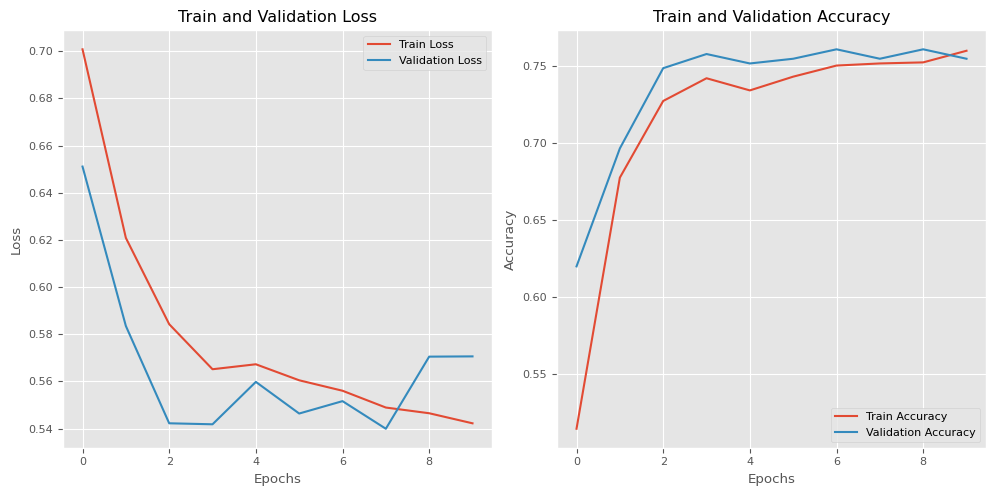

In [70]:
# train and valid losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(eval_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Evaluation Accuracy: 0.7546
Confusion Matrix:
[[134  29]
 [ 51 112]]
Precision: 0.7943
Recall: 0.6871
F1 Score: 0.7368
Area Under the ROC Curve (AUC) 0.8199781700477999


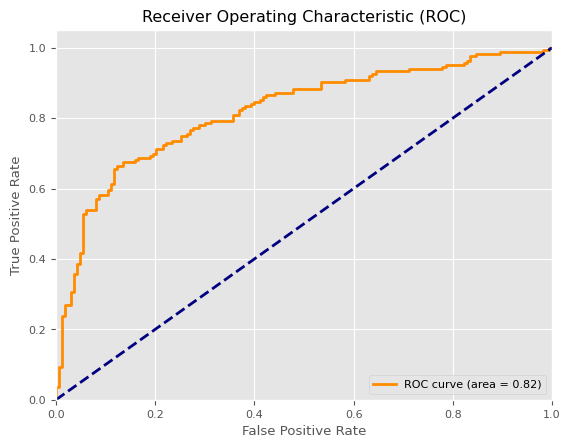

In [71]:

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

# evaluate
model.eval()
with torch.no_grad():
  outputs = model(X_eval_tensor)
  _, predicted = torch.max(outputs, 1)
  accuracy = (predicted == y_eval_tensor).sum().item() / len(y_eval_tensor)
  print(f"Evaluation Accuracy: {accuracy:.4f}")

  # confusion matrix
  cm = confusion_matrix(y_eval_tensor.cpu().numpy(), predicted.cpu().numpy())
  print(f"Confusion Matrix:\n{cm}")

  # Precision, Recall, F1 Score
  precision = precision_score(y_eval_tensor.cpu().numpy(), predicted.cpu().numpy(), pos_label=1)
  recall = recall_score(y_eval_tensor.cpu().numpy(), predicted.cpu().numpy(), pos_label=1)
  f1 = f1_score(y_eval_tensor.cpu().numpy(), predicted.cpu().numpy(), pos_label=1)

  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")

  # ROC and AUC calculation
  y_proba = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # probabilities for class 1
  fpr, tpr, _ = roc_curve(y_eval_tensor.cpu().numpy(), y_proba)
  roc_auc = auc(fpr, tpr)
  print('Area Under the ROC Curve (AUC)', roc_auc)

  # Plot ROC curve
  plt.figure()
  plt.rcParams.update({'font.size': 8})

  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC)')
  plt.legend(loc="lower right")
  plt.show()

  # np.savez(file_path + 'results_pre_blood_best_roc.npz', fpr=fpr, tpr=tpr, roc_auc=roc_auc)

# custom Multi-head self-attention and Feed-forward network

In [81]:
############# custom Multi-head self-attention and Feed-forward network

# mTAND embedding layer
class MTANDEmbedding(nn.Module):
    def __init__(self, input_size, embedding_dim):
        super(MTANDEmbedding, self).__init__()
        self.lstm = nn.LSTM(input_size, embedding_dim, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(embedding_dim * 2, embedding_dim)  # bidirectional LSTM output

    def forward(self, x):
        # LSTM output
        x, _ = self.lstm(x)
        # bidirectional lstm to embedding_dim
        x = self.linear(x)
        return x


# Transformer encoder layer
class TransformerEncoderLayer(nn.Module):
    def __init__(self, hidden_size, nhead, ff_dim, dropout_prob):
        super(TransformerEncoderLayer, self).__init__()

        # Multi-head self-attention layer
        self.self_attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=nhead, batch_first=True)

        # Feed-forward network (2 dense layers with ReLU activation)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_size, ff_dim),  # Feed-forward network hidden layer # 第1个全连接层
            nn.ReLU(), #activation func
            nn.Linear(ff_dim, hidden_size) # 第二个全连接层
        )

        # Layer normalization layers after attention and feed-forward network
        # self.layer_norm1 = nn.LayerNorm(hidden_size)
        # self.layer_norm2 = nn.LayerNorm(hidden_size)
        self.layer_norm1 = nn.LayerNorm(hidden_size, eps=1e-6)
        self.layer_norm2 = nn.LayerNorm(hidden_size, eps=1e-6)

        # Dropout layers for regularization
        self.dropout1 = nn.Dropout(dropout_prob)
        self.dropout2 = nn.Dropout(dropout_prob)

    def forward(self, x):
        # Multi-head self-attention
        attn_out, _ = self.self_attention(x, x, x)  # Self-attention
        x = self.layer_norm1(x + self.dropout1(attn_out))  # Residual connection and layer normalization

        # Feed-forward network
        ff_out = self.feed_forward(x)
        x = self.layer_norm2(x + self.dropout2(ff_out))  # Residual connection and layer normalization

        return x



# Transformer encoder
class AlzSeqTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_heads, ff_dim, dropout_prob, max_position):
        super(AlzSeqTransformer, self).__init__()

        # mTAND embedding layer
        self.mtand_embedding = MTANDEmbedding(input_size, hidden_size)

        # Positional encoding
        self.positional_encoding = self.create_positional_encoding(max_position, hidden_size)

        # Stack of Transformer Encoder Layers
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderLayer(hidden_size, num_heads, ff_dim, dropout_prob) for _ in range(num_layers)
        ])

        # Classification head
        self.fc = nn.Linear(hidden_size, 2)  # Assuming binary classification

    def create_positional_encoding(self, position, embedding_dim):
        """Function to create positional encodings."""
        angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(embedding_dim)[np.newaxis, :] // 2)) / np.float32(embedding_dim))
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = torch.tensor(angle_rads[np.newaxis, ...], dtype=torch.float32)
        return pos_encoding

    def forward(self, x):
        # Pad sequences to the same length
        x_padded = rnn_utils.pad_sequence(x, batch_first=True)

        # Apply mTAND embedding
        embedded = self.mtand_embedding(x_padded)

        # Get the actual sequence length
        seq_length = embedded.size(1)  # Get the sequence length from the embedded input

        # Create positional encoding based on the actual sequence length
        positional_encodings = self.create_positional_encoding(seq_length, embedded.size(2)).to(embedded.device)  # Create positional encodings based on actual seq_length

        # Combine embedding and positional encoding
        embedded_with_pos = embedded + positional_encodings  # Combine embedding and positional encoding

        # Pass through each Transformer encoder layer
        for layer in self.transformer_layers:
            embedded_with_pos = layer(embedded_with_pos)  # Update the embedding with layer output

        # Mean pooling over the sequence length dimension
        transformer_out = embedded_with_pos.mean(dim=1)  # Mean pooling over time steps
        out = self.fc(transformer_out)  # Final output layer
        return out



## Hyperparameters

In [82]:
# init
input_size = X_train_tensor[0].shape[1]  # Embedding dimension = 21 ；使用 mTAND 嵌入前的特征数
hidden_size = 64 # Embedding size, Embedding dimension for output
num_layers = 2 # Number of Transformer Encoder layers
num_heads = 8 # Number of attention heads
dropout_prob = 0.1
max_position = 50  # Maximum sequence length
ff_dim = 128  # Feed-forward dimension

In [83]:
# init model and optimizer
# model = AlzSeqTransformer(input_size, hidden_size, num_layers, num_heads, dropout_prob, max_position)
model = AlzSeqTransformer(input_size, hidden_size, num_layers, num_heads, ff_dim, dropout_prob, max_position)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


print(model)
# tf.keras.utils.plot_model(model,
#                           to_file='output/transformer_encoder_CustomFocalLoss.png',
#                           show_shapes=True, expand_nested=True)


AlzSeqTransformer(
  (mtand_embedding): MTANDEmbedding(
    (lstm): LSTM(21, 64, batch_first=True, bidirectional=True)
    (linear): Linear(in_features=128, out_features=64, bias=True)
  )
  (transformer_layers): ModuleList(
    (0-1): 2 x TransformerEncoderLayer(
      (self_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (feed_forward): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=64, bias=True)
      )
      (layer_norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (layer_norm2): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (fc): Linear(in_features=64, out_features=2, bias=True)
)


## Compiling the Model

In [84]:
# from tensorflow.keras.callbacks import EarlyStopping

# Define constants
# num_epochs = 10
# batch_size = 32
num_epochs = 50
batch_size = 16

train_losses = []
eval_losses = []
train_accs = []
train_f1s = []
eval_accs = []
eval_f1s = []

# early stopping constants
patience = 3
best_eval_acc = 0
counter = 0


# train
for epoch in range(num_epochs):
  model.train()
  permutation = torch.randperm(len(X_train_tensor)) #random
  epoch_loss = 0.0
  correct_pred = 0
  total_pred = 0

  for i in range(0, len(X_train_tensor), batch_size):
    optimizer.zero_grad()

    batch_indices = permutation[i:i + batch_size]
    batch_X = [X_train_tensor[idx] for idx in batch_indices]
    batch_y = y_train_tensor[batch_indices]

    # feed forward
    outputs = model(batch_X)
    loss = criterion(outputs, batch_y)
    _, predicted = torch.max(outputs, 1)
    total_pred += batch_y.size(0)
    correct_pred += (predicted == batch_y).sum().item()

    # back prop
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  train_loss = epoch_loss / int(len(X_train_tensor)/batch_size)
  train_losses.append(train_loss)
  train_acc = correct_pred / total_pred
  train_accs.append(train_acc)

  # validation loss
  model.eval()
  with torch.no_grad():
    eval_outputs = model(X_eval_tensor)
    # print(eval_outputs)
    # print(y_eval_tensor)
    eval_loss = criterion(eval_outputs, y_eval_tensor).item()
    _, eval_predicted = torch.max(eval_outputs, 1)
    eval_acc = (eval_predicted == y_eval_tensor).sum().item() / len(y_eval_tensor)
    eval_losses.append(eval_loss)
    eval_accs.append(eval_acc)

  print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}, Train Acc: {train_acc:.4f}, Eval Acc: {eval_acc:.4f}")

  # Save the model checkpoint
  checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch + 1}.pth')
  torch.save({
      'epoch': epoch + 1,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'train_loss': train_loss,
      'eval_loss': eval_loss,
      'train_acc': train_acc,
      'eval_acc': eval_acc
  }, checkpoint_path)

  # Early stopping
  if eval_acc > best_eval_acc:
      best_eval_acc = eval_acc
      counter = 0
      best_model_state = model.state_dict()
  else:
      counter += 1
      if counter >= patience:
          print(f"Early stopping at epoch {epoch + 1}")
          model.load_state_dict(best_model_state)
          break



Epoch [1/50], Train Loss: 0.6947, Eval Loss: 0.6746, Train Acc: 0.5316, Eval Acc: 0.6104
Epoch [2/50], Train Loss: 0.6766, Eval Loss: 0.6809, Train Acc: 0.5825, Eval Acc: 0.5429
Epoch [3/50], Train Loss: 0.6578, Eval Loss: 0.6309, Train Acc: 0.6251, Eval Acc: 0.6994
Epoch [4/50], Train Loss: 0.6174, Eval Loss: 0.5950, Train Acc: 0.6904, Eval Acc: 0.6994
Epoch [5/50], Train Loss: 0.6017, Eval Loss: 0.5917, Train Acc: 0.7021, Eval Acc: 0.7147
Epoch [6/50], Train Loss: 0.5868, Eval Loss: 0.5750, Train Acc: 0.7199, Eval Acc: 0.7209
Epoch [7/50], Train Loss: 0.5735, Eval Loss: 0.5778, Train Acc: 0.7261, Eval Acc: 0.7055
Epoch [8/50], Train Loss: 0.5684, Eval Loss: 0.5616, Train Acc: 0.7275, Eval Acc: 0.7301
Epoch [9/50], Train Loss: 0.5587, Eval Loss: 0.5783, Train Acc: 0.7354, Eval Acc: 0.7055
Epoch [10/50], Train Loss: 0.5563, Eval Loss: 0.5569, Train Acc: 0.7351, Eval Acc: 0.7393
Epoch [11/50], Train Loss: 0.5597, Eval Loss: 0.5541, Train Acc: 0.7309, Eval Acc: 0.7301
Epoch [12/50], Trai

# Testing and Evaluation

## train and valid: Accuracy and Loss

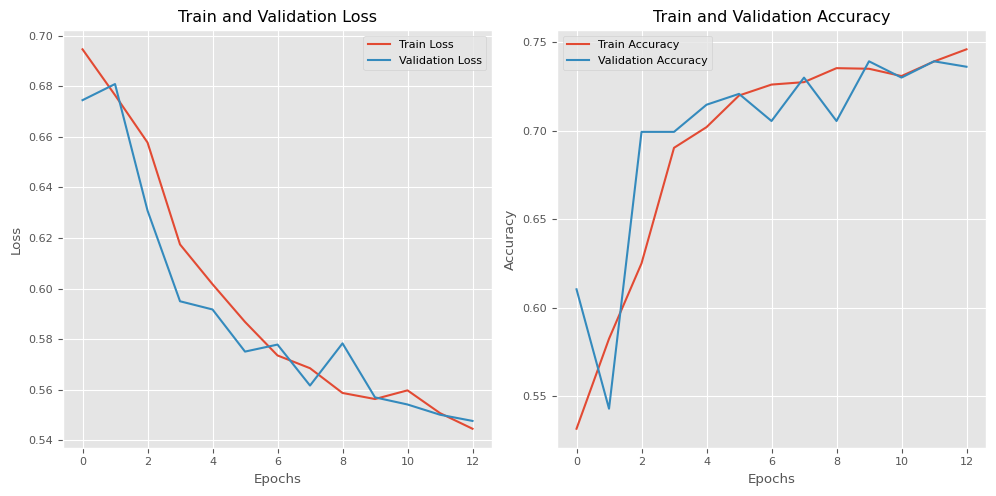

In [85]:
#### plot
# train and valid losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(eval_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## use the best epoch

In [86]:
# Function to load a specific model checkpoint
def load_model_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    eval_loss = checkpoint['eval_loss']
    train_acc = checkpoint['train_acc']
    eval_acc = checkpoint['eval_acc']

    print(f"Loaded model from epoch {epoch}: Train Loss = {train_loss:.4f}, Eval Loss = {eval_loss:.4f}, Train Acc = {train_acc:.4f}, Eval Acc = {eval_acc:.4f}")
    return model, optimizer

# Change number for best epoch
usedmodel, optimizer = load_model_checkpoint(checkpoint_dir + '/epoch_13.pth', model, optimizer) # checkpoint_dir + '/BEST-EPOCH-YOU-CHOOSE.pth'



Loaded model from epoch 13: Train Loss = 0.5445, Eval Loss = 0.5476, Train Acc = 0.7460, Eval Acc = 0.7362


<ipython-input-86-26eefabc6943>:3: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



## Precision, recall, F1 socre, AUC, ROC curve

Evaluation Accuracy: 0.7362
Confusion Matrix:
[[115  48]
 [ 38 125]]
Precision: 0.7225
Recall: 0.7669
F1 Score: 0.7440
Area Under the ROC Curve (AUC) 0.8002935752192405


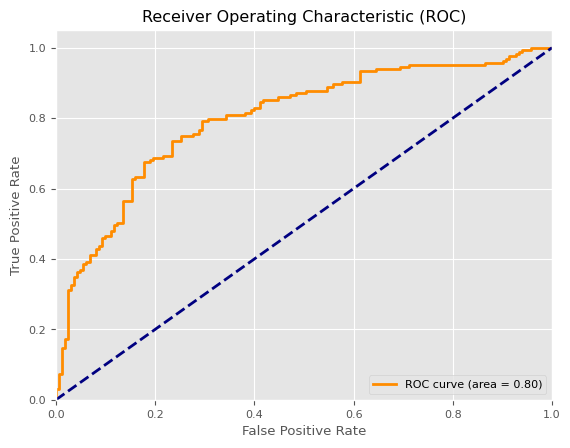

In [87]:

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

# evaluate
usedmodel.eval()
with torch.no_grad():
  outputs = usedmodel(X_eval_tensor)
  _, predicted = torch.max(outputs, 1)
  accuracy = (predicted == y_eval_tensor).sum().item() / len(y_eval_tensor)
  print(f"Evaluation Accuracy: {accuracy:.4f}")

  # confusion matrix
  cm = confusion_matrix(y_eval_tensor.cpu().numpy(), predicted.cpu().numpy())
  print(f"Confusion Matrix:\n{cm}")

  # Precision, Recall, F1 Score
  precision = precision_score(y_eval_tensor.cpu().numpy(), predicted.cpu().numpy(), pos_label=1)
  recall = recall_score(y_eval_tensor.cpu().numpy(), predicted.cpu().numpy(), pos_label=1)
  f1 = f1_score(y_eval_tensor.cpu().numpy(), predicted.cpu().numpy(), pos_label=1)

  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")

  # ROC and AUC calculation
  y_proba = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # probabilities for class 1
  fpr, tpr, _ = roc_curve(y_eval_tensor.cpu().numpy(), y_proba)
  roc_auc = auc(fpr, tpr)
  print('Area Under the ROC Curve (AUC)', roc_auc)

  # Plot ROC curve
  plt.figure()
  plt.rcParams.update({'font.size': 8})

  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC)')
  plt.legend(loc="lower right")
  plt.show()


In [173]:
# save current best ROC
np.savez(file_path + 'results_pre_blood_best_roc.npz', fpr=fpr, tpr=tpr, roc_auc=roc_auc)


# Tune hyper - Bayesian Optimization

In [98]:
import optuna
from sklearn.model_selection import train_test_split
import torch

# define hyper
def objective(trial):
    # hypers
    hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    num_heads = trial.suggest_categorical('num_heads', [4, 8])
    ff_dim = trial.suggest_categorical('ff_dim', [64, 128, 256])
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)  # 使用 suggest_float

    # 80% train，20% validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_tensor, y_train_tensor, test_size=0.2, random_state=42
    )

    # init model
    model = AlzSeqTransformer(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        num_heads=num_heads,
        ff_dim=ff_dim,
        dropout_prob=dropout_prob,
        max_position=max_position
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    # train
    model.train()
    epoch_loss = 0.0
    correct_pred = 0
    total_pred = 0

    for i in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        # transform
        batch_X = torch.nn.utils.rnn.pad_sequence(X_train[i:i + batch_size], batch_first=True)
        batch_y = torch.tensor(y_train[i:i + batch_size])

        # forward
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_pred += batch_y.size(0)
        correct_pred += (predicted == batch_y).sum().item()

    # acc
    train_accuracy = correct_pred / total_pred

    # eva
    model.eval()
    val_correct_pred = 0
    val_total_pred = 0

    with torch.no_grad():
        for i in range(0, len(X_val), batch_size):
            batch_X_val = torch.nn.utils.rnn.pad_sequence(X_val[i:i + batch_size], batch_first=True)
            batch_y_val = torch.tensor(y_val[i:i + batch_size])

            outputs_val = model(batch_X_val)
            _, predicted_val = torch.max(outputs_val, 1)

            val_total_pred += batch_y_val.size(0)
            val_correct_pred += (predicted_val == batch_y_val).sum().item()


    val_accuracy = val_correct_pred / val_total_pred

    # return val acc
    return val_accuracy

# optimize hyper
study = optuna.create_study(direction="maximize")  # Maximizing validation accuracy
study.optimize(objective, n_trials=20)

# output best hyper
print(f"Best trial: {study.best_trial.params}")


[I 2024-10-24 12:24:35,757] A new study created in memory with name: no-name-0b98d2e9-6da9-4708-9c1b-ccf5cca97cc9
<ipython-input-98-4dc9c07eecc6>:44: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

<ipython-input-98-4dc9c07eecc6>:68: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

[I 2024-10-24 12:24:55,006] Trial 0 finished with value: 0.5532646048109966 and parameters: {'hidden_size': 32, 'num_layers': 1, 'num_heads': 8, 'ff_dim': 256, 'dropout_prob': 0.39259482692526004, 'lr': 1.7775898266759672e-05}. Best is trial 0 with value: 0.5532646048109966.
[I 2024-10-24 12:25:59,259] Trial 1 finished with value: 0.584192439862543 and parameters: {'hidden_size': 128, 'num_layers': 3, 'num_heads': 

Best trial: {'hidden_size': 64, 'num_layers': 2, 'num_heads': 4, 'ff_dim': 64, 'dropout_prob': 0.11331229211824995, 'lr': 0.0005508869141298536}


In [99]:
import optuna
from sklearn.model_selection import KFold
import torch
import numpy as np
import random

# set random seeds
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

def objective(trial):
    hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    num_heads = trial.suggest_categorical('num_heads', [4, 8])
    ff_dim = trial.suggest_categorical('ff_dim', [64, 128, 256])
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)  # 使用 suggest_float

    # K-Fold Cross-Validation (5 cross)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_accuracies = []

    for train_idx, val_idx in kfold.split(X_train_tensor):
        model = AlzSeqTransformer(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            num_heads=num_heads,
            ff_dim=ff_dim,
            dropout_prob=dropout_prob,
            max_position=max_position
        )
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()

        X_train_fold = [X_train_tensor[i] for i in train_idx]
        X_val_fold = [X_train_tensor[i] for i in val_idx]
        y_train_fold = [y_train_tensor[i] for i in train_idx]
        y_val_fold = [y_train_tensor[i] for i in val_idx]

        # train
        model.train()
        for i in range(0, len(X_train_fold), batch_size):
            optimizer.zero_grad()

            # padding
            batch_X = torch.nn.utils.rnn.pad_sequence(X_train_fold[i:i + batch_size], batch_first=True)
            batch_y = torch.tensor(y_train_fold[i:i + batch_size])

            # froward and backward
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        # eval
        model.eval()
        val_correct_pred = 0
        val_total_pred = 0

        with torch.no_grad():
            for i in range(0, len(X_val_fold), batch_size):
                batch_X_val = torch.nn.utils.rnn.pad_sequence(X_val_fold[i:i + batch_size], batch_first=True)
                batch_y_val = torch.tensor(y_val_fold[i:i + batch_size])

                outputs_val = model(batch_X_val)
                _, predicted_val = torch.max(outputs_val, 1)

                val_total_pred += batch_y_val.size(0)
                val_correct_pred += (predicted_val == batch_y_val).sum().item()


        fold_accuracy = val_correct_pred / val_total_pred
        fold_accuracies.append(fold_accuracy)


    mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)


    return mean_accuracy


study = optuna.create_study(direction="maximize")  # Maximizing validation accuracy
study.optimize(objective, n_trials=20)


print(f"Best trial: {study.best_trial.params}")


[I 2024-10-24 12:36:03,758] A new study created in memory with name: no-name-18f794c4-20d2-46ec-ad7d-124f4d2d08ee
[I 2024-10-24 12:37:08,508] Trial 0 finished with value: 0.470446735395189 and parameters: {'hidden_size': 32, 'num_layers': 1, 'num_heads': 8, 'ff_dim': 64, 'dropout_prob': 0.32882206667015, 'lr': 2.2577000762796165e-05}. Best is trial 0 with value: 0.470446735395189.
[I 2024-10-24 12:38:24,691] Trial 1 finished with value: 0.49690721649484537 and parameters: {'hidden_size': 32, 'num_layers': 2, 'num_heads': 4, 'ff_dim': 128, 'dropout_prob': 0.16618976993289125, 'lr': 1.679343318007721e-05}. Best is trial 1 with value: 0.49690721649484537.
[I 2024-10-24 12:39:14,019] Trial 2 finished with value: 0.49587628865979383 and parameters: {'hidden_size': 32, 'num_layers': 1, 'num_heads': 4, 'ff_dim': 128, 'dropout_prob': 0.35961836636178657, 'lr': 0.0001225216607246237}. Best is trial 1 with value: 0.49690721649484537.
[I 2024-10-24 12:42:58,247] Trial 3 finished with value: 0.495

Best trial: {'hidden_size': 64, 'num_layers': 1, 'num_heads': 4, 'ff_dim': 128, 'dropout_prob': 0.23277717025340344, 'lr': 1.7153426979824913e-05}


## re-complie using optimal hyperparameter


Epoch [1/50], Train Loss: 0.6791, Eval Loss: 0.6573, Train Acc: 0.5780, Eval Acc: 0.5521
Epoch [2/50], Train Loss: 0.5961, Eval Loss: 0.5965, Train Acc: 0.7034, Eval Acc: 0.7025
Epoch [3/50], Train Loss: 0.5760, Eval Loss: 0.5580, Train Acc: 0.7306, Eval Acc: 0.7577
Epoch [4/50], Train Loss: 0.5547, Eval Loss: 0.5362, Train Acc: 0.7416, Eval Acc: 0.7515
Epoch [5/50], Train Loss: 0.5416, Eval Loss: 0.5465, Train Acc: 0.7495, Eval Acc: 0.7699
Epoch [6/50], Train Loss: 0.5328, Eval Loss: 0.5327, Train Acc: 0.7505, Eval Acc: 0.7669
Epoch [7/50], Train Loss: 0.5320, Eval Loss: 0.5387, Train Acc: 0.7522, Eval Acc: 0.7454
Epoch [8/50], Train Loss: 0.5190, Eval Loss: 0.5379, Train Acc: 0.7619, Eval Acc: 0.7638
Early stopping at epoch 8


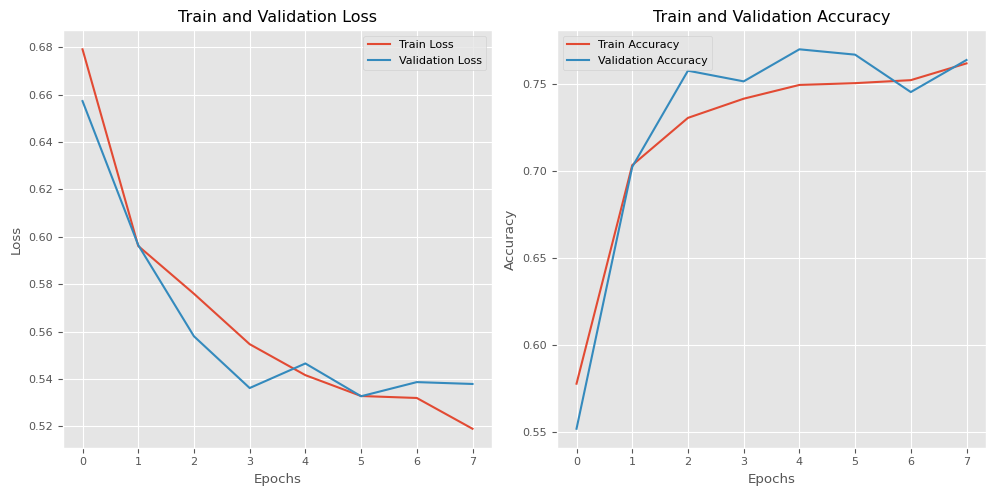

In [100]:
# Best trial: {'hidden_size': 64, 'num_layers': 2, 'num_heads': 4, 'ff_dim': 64, 'dropout_prob': 0.11331229211824995, 'lr': 0.0005508869141298536}
# Best trial: {'hidden_size': 64, 'num_layers': 1, 'num_heads': 4, 'ff_dim': 128, 'dropout_prob': 0.23277717025340344, 'lr': 1.7153426979824913e-05}

# init
input_size = X_train_tensor[0].shape[1]  # Embedding dimension = 21 ；使用 mTAND 嵌入前的特征数
hidden_size = 64 # Embedding size, Embedding dimension for output
num_layers = 2 # Number of Transformer Encoder layers
num_heads = 4 # Number of attention heads
dropout_prob = 0.1
lr = 0.00055
max_position = 50  # Maximum sequence length
ff_dim = 64  # Feed-forward dimension


# init model and optimizer
# model = AlzSeqTransformer(input_size, hidden_size, num_layers, num_heads, dropout_prob, max_position)
model = AlzSeqTransformer(input_size, hidden_size, num_layers, num_heads, ff_dim, dropout_prob, max_position)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


# from tensorflow.keras.callbacks import EarlyStopping

# Define constants
# num_epochs = 10
# batch_size = 32
num_epochs = 50
batch_size = 16

train_losses = []
eval_losses = []
train_accs = []
train_f1s = []
eval_accs = []
eval_f1s = []

# early stopping constants
patience = 3
best_eval_acc = 0
counter = 0


# train
for epoch in range(num_epochs):
  model.train()
  permutation = torch.randperm(len(X_train_tensor)) #random
  epoch_loss = 0.0
  correct_pred = 0
  total_pred = 0

  for i in range(0, len(X_train_tensor), batch_size):
    optimizer.zero_grad()

    batch_indices = permutation[i:i + batch_size]
    batch_X = [X_train_tensor[idx] for idx in batch_indices]
    batch_y = y_train_tensor[batch_indices]

    # feed forward
    outputs = model(batch_X)
    loss = criterion(outputs, batch_y)
    _, predicted = torch.max(outputs, 1)
    total_pred += batch_y.size(0)
    correct_pred += (predicted == batch_y).sum().item()

    # back prop
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  train_loss = epoch_loss / int(len(X_train_tensor)/batch_size)
  train_losses.append(train_loss)
  train_acc = correct_pred / total_pred
  train_accs.append(train_acc)

  # validation loss
  model.eval()
  with torch.no_grad():
    eval_outputs = model(X_eval_tensor)
    # print(eval_outputs)
    # print(y_eval_tensor)
    eval_loss = criterion(eval_outputs, y_eval_tensor).item()
    _, eval_predicted = torch.max(eval_outputs, 1)
    eval_acc = (eval_predicted == y_eval_tensor).sum().item() / len(y_eval_tensor)
    eval_losses.append(eval_loss)
    eval_accs.append(eval_acc)

  print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}, Train Acc: {train_acc:.4f}, Eval Acc: {eval_acc:.4f}")

  # Save the model checkpoint
  checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch + 1}.pth')
  torch.save({
      'epoch': epoch + 1,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'train_loss': train_loss,
      'eval_loss': eval_loss,
      'train_acc': train_acc,
      'eval_acc': eval_acc
  }, checkpoint_path)

  # Early stopping
  if eval_acc > best_eval_acc:
      best_eval_acc = eval_acc  # 更新最佳验证准确率
      counter = 0  # 重置 patience 计数器
      best_model_state = model.state_dict()  # 保存最佳模型参数
  else:
      counter += 1
      if counter >= patience:
          print(f"Early stopping at epoch {epoch + 1}")
          model.load_state_dict(best_model_state)  # 恢复最佳模型参数
          break  # 提前停止训练



#### plot
# train and valid losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(eval_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


use best epoch and plot ROC

<ipython-input-101-d7e0e42a468f>:3: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Loaded model from epoch 6: Train Loss = 0.5328, Eval Loss = 0.5327, Train Acc = 0.7505, Eval Acc = 0.7669
Evaluation Accuracy: 0.7669
Confusion Matrix:
[[126  37]
 [ 39 124]]
Precision: 0.7702
Recall: 0.7607
F1 Score: 0.7654
Area Under the ROC Curve (AUC) 0.8069178365764613


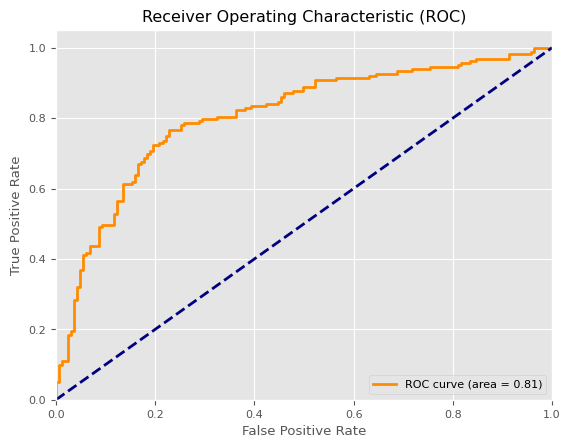

In [101]:
# Function to load a specific model checkpoint
def load_model_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    eval_loss = checkpoint['eval_loss']
    train_acc = checkpoint['train_acc']
    eval_acc = checkpoint['eval_acc']

    print(f"Loaded model from epoch {epoch}: Train Loss = {train_loss:.4f}, Eval Loss = {eval_loss:.4f}, Train Acc = {train_acc:.4f}, Eval Acc = {eval_acc:.4f}")
    return model, optimizer

# Change number for best epoch
usedmodel, optimizer = load_model_checkpoint(checkpoint_dir + '/epoch_6.pth', model, optimizer) # checkpoint_dir + '/BEST-EPOCH-YOU-CHOOSE.pth'



# plot
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

# evaluate
usedmodel.eval()
with torch.no_grad():
  outputs = usedmodel(X_eval_tensor)
  _, predicted = torch.max(outputs, 1)
  accuracy = (predicted == y_eval_tensor).sum().item() / len(y_eval_tensor)
  print(f"Evaluation Accuracy: {accuracy:.4f}")

  # confusion matrix
  cm = confusion_matrix(y_eval_tensor.cpu().numpy(), predicted.cpu().numpy())
  print(f"Confusion Matrix:\n{cm}")

  # Precision, Recall, F1 Score
  precision = precision_score(y_eval_tensor.cpu().numpy(), predicted.cpu().numpy(), pos_label=1)
  recall = recall_score(y_eval_tensor.cpu().numpy(), predicted.cpu().numpy(), pos_label=1)
  f1 = f1_score(y_eval_tensor.cpu().numpy(), predicted.cpu().numpy(), pos_label=1)

  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")

  # ROC and AUC calculation
  y_proba = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # probabilities for class 1
  fpr, tpr, _ = roc_curve(y_eval_tensor.cpu().numpy(), y_proba)
  roc_auc = auc(fpr, tpr)
  print('Area Under the ROC Curve (AUC)', roc_auc)

  # Plot ROC curve
  plt.figure()
  plt.rcParams.update({'font.size': 8})

  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC)')
  plt.legend(loc="lower right")
  plt.show()
